In [4]:
"""
Generate PPH for annual NCEI_storm_reports
Remember to run the latlong filter script first
Honestly could've been done with the single CSV file but I'm too lazy to change previous code

Code adapted for NOAA Storm Reports format"
Processing Storm_Reports_YYYY_latlong.csv files from 1950-2024
"""

import numpy as np
import os
import pandas as pd
import xarray as xr


sigma_grid_units = 1.5
grid_spacing_km = 40.0   

# Download and Load NAM-212 grid 
url = 'https://github.com/ahaberlie/PPer_Climo/tree/master/data'
try:
    grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
    grid212_lat = grid_ds["gridlat_212"].values  # (ny, nx)
    grid212_lon = grid_ds["gridlon_212"].values  # (ny, nx)
    print(f"Loaded grid with shape: {grid212_lat.shape}")
except Exception as e:
    print(f"Error loading grid file: {e}")
    exit(1)

# Storm type mapping from EVENT_TYPE
storm_types = {
    "Tornado": "torn",
    "Thunderstorm Wind": "wind", 
    "Strong Wind": "wind",
    "High Wind": "wind",
    "Hail": "hail"
}

# Distance function for PPH
def euclidean_distance_km(grid_lat, grid_lon, report_lat, report_lon):
    lat_km = 111.32 * (grid_lat - report_lat)
    lon_km = 111.32 * np.cos(np.radians(report_lat)) * (grid_lon - report_lon)
    return np.sqrt(lat_km**2 + lon_km**2)

# Create output directory
output_folder = "NCEI_PPH"
os.makedirs(output_folder, exist_ok=True)

# Create output subfolders for each storm type
for storm_type in storm_types.values():
    output_subfolder = os.path.join(output_folder, storm_type)
    os.makedirs(output_subfolder, exist_ok=True)

# Process each year from 2010-2024
for year in range(2009, 2025):  #2010 to 2024 inclusive
    file_path = f"/USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/filtered/Storm_Reports_{year}_latlong.csv"
    #change to your filepath
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue

    try:
        print(f"\nProcessing {file_path}...")
        
        # Read the data
        data = pd.read_csv(file_path)
        
        # Clean and convert data types
        data['BEGIN_LAT'] = pd.to_numeric(data['BEGIN_LAT'], errors='coerce')
        data['BEGIN_LON'] = pd.to_numeric(data['BEGIN_LON'], errors='coerce')
        data['BEGIN_DAY'] = pd.to_numeric(data['BEGIN_DAY'], errors='coerce')
        data['MONTH_NUM'] = pd.to_numeric(data['MONTH_NUM'], errors='coerce')
        
        # Remove rows with missing critical data
        initial_count = len(data)
        data = data.dropna(subset=['BEGIN_LAT', 'BEGIN_LON', 'BEGIN_DAY', 'MONTH_NUM', 'EVENT_TYPE'])
        if len(data) < initial_count:
            print(f"  Removed {initial_count - len(data)} rows with missing data")

        # Filter to CONUS bounds
        conus_data = data[(data['BEGIN_LAT'] >= 24.52) & (data['BEGIN_LAT'] <= 49.385) &
                         (data['BEGIN_LON'] >= -124.74) & (data['BEGIN_LON'] <= -66.95)]

        if len(conus_data) < len(data):
            print(f"  Filtered {len(data) - len(conus_data)} reports outside CONUS")
        
        data = conus_data

        if len(data) == 0:
            print(f"  No valid data for {year}")
            continue

        # Process each storm type
        for event_type, storm_type in storm_types.items():
            print(f"  Processing {event_type} reports...")
            
            # Filter data for this storm type
            storm_data = data[data['EVENT_TYPE'] == event_type].copy()
            
            if len(storm_data) == 0:
                print(f"    No {event_type} reports for {year}")
                continue
                
            print(f"    Found {len(storm_data)} {event_type} reports")
            
            # Get output subfolder for this storm type
            output_subfolder = os.path.join(output_folder, storm_type)
            
            # Process each month
            for month in range(1, 13):
                month_data = storm_data[storm_data['MONTH_NUM'] == month].copy()
                
                if len(month_data) == 0:
                    continue
                
                # Process each day in the month
                for day in sorted(month_data['BEGIN_DAY'].unique()):
                    day_data = month_data[month_data['BEGIN_DAY'] == day]
                    
                    if len(day_data) == 0:
                        continue
                    
                    # Initialize the sum for PPH
                    gaussian_sum = np.zeros_like(grid212_lat, dtype=np.float64)

                    # Compute the PPH 
                    for _, row in day_data.iterrows():
                        d_km = euclidean_distance_km(
                            grid212_lat, grid212_lon,
                            row['BEGIN_LAT'], row['BEGIN_LON']
                        )
                        
                        # Convert to grid units 
                        d_grid = d_km / grid_spacing_km
                        
                        # Summing the Nth terms 
                        gaussian_sum += np.exp(-0.5 * (d_grid / sigma_grid_units) ** 2)

                    # Apply prefactor: (1 / (2π sigma²)) 
                    gauss_pref = 1.0 / (2.0 * np.pi * sigma_grid_units**2)
                    daily_pph = gauss_pref * gaussian_sum
                    rounded_pph = np.round(daily_pph, 10)

                    # Saving
                    file_name_out = f"pph_{year}_{month:02d}_{int(day):02d}.csv"
                    output_file = os.path.join(output_subfolder, file_name_out)

                    try:
                        df = pd.DataFrame(rounded_pph)
                        df.to_csv(output_file, index=False)
                        
                        print(f"    Calculated PPH for {storm_type} on {year}-{month:02d}-{int(day):02d} ({len(day_data)} reports)")
                        
                    except Exception as e:
                        print(f"    Error saving PPH for {year}-{month:02d}-{int(day):02d}: {e}")
                        continue

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        continue

print("\nNOAA Storm Reports PPH processing complete!")

Loaded grid with shape: (129, 185)
File does not exist: /USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/filtered/Storm_Reports_2009_latlong.csv

Processing /USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/filtered/Storm_Reports_2010_latlong.csv...
  Removed 3736 rows with missing data
  Filtered 22 reports outside CONUS
  Processing Tornado reports...
    Found 1449 Tornado reports
    Calculated PPH for torn on 2010-01-18 (1 reports)
    Calculated PPH for torn on 2010-01-19 (2 reports)
    Calculated PPH for torn on 2010-01-20 (15 reports)
    Calculated PPH for torn on 2010-01-21 (12 reports)
    Calculated PPH for torn on 2010-01-22 (2 reports)
    Calculated PPH for torn on 2010-01-23 (1 reports)
    Calculated PPH for torn on 2010-01-24 (1 reports)
    Calculated PPH for torn on 2010-02-27 (1 reports)
    Calculated PPH for torn on 2010-03-08 (4 reports)
    Calculated PPH for torn on 2010-03-10 (11 reports)
    Calculated PPH for torn on 2010-03-11 (5 reports)
    Calculated 

In [5]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"WIP"
"Code graphs the nam212_pph and attempts to replicate the Research paper's visualizations"
"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climo'

# Load NAM-212 grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities to plot
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Columbus, OH': (-82.9988, 39.9612),
        'Albany, NY': (-73.7562, 42.6526),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'Tuscaloosa, AL': (-87.5692, 33.2098), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Orlando, FL': (-81.3792, 28.5383), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data with more visible black color
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = f"ncei_pph/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs, output_dir="Mean_Annual_Event_Days_Graphs"):
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created directory: {output_dir}")
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'torn': ['#ffffff','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000'],
        'hail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
        'wind': ['#ffffff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    }
    
    # Scales adjusted for PPH values
    scales = {
        'torn': {
            0.05: [0, 0.1, 0.5, 1.0, 2.0, 5.0, 100],
            0.15: [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100],
            0.30: [0, 0.2, 0.5, 1.0, 2.0, 4.0, 100]
        },
        'hail': {
            0.05: [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100],
            0.15: [0, 1.0, 2.0, 4.0, 8.0, 12.0, 100],
            0.30: [0, 0.5, 1.0, 2.0, 4.0, 6.0, 100]
        },
        'wind': {
            0.05: [0, 1.0, 2.0, 4.0, 8.0, 12.0, 100],
            0.15: [0, 2.0, 4.0, 8.0, 12.0, 16.0, 100],
            0.30: [0, 1.0, 2.0, 4.0, 6.0, 8.0, 100]
        }
    }
    
    storm_names = {
        'torn': 'Tornado',
        'hail': 'Hail', 
        'wind': 'Wind'
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                # Convert to xarray DataArray
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations with larger, bolder crosses
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with larger markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                

                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                # Create filename and save image
                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
                print(f"Saved: {filepath}")
                
                plt.close()
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Storm thresholds
storm_configs = {
    'torn': [0.05, 0.10, 0.15, 0.30, 0.60],    # 5% threshold
    'wind': [0.05, 0.10, 0.15, 0.30, 0.60],    # 15% threshold  
    'hail': [0.05, 0.10, 0.15, 0.30, 0.60]     # 15% threshold
}

start_year = 2010 
end_year = 2024

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

Processing torn at 5.0% severity...
Processed 2576 days for torn, 15 years
Maximum value: 6.800 at 2 locations
Saved: Mean_Annual_Event_Days_Graphs/torn_5pct_2010-2024.png
Processing torn at 10.0% severity...
Processed 2576 days for torn, 15 years
Maximum value: 4.600 at 1 locations
Saved: Mean_Annual_Event_Days_Graphs/torn_10pct_2010-2024.png
Processing torn at 15.0% severity...
Processed 2576 days for torn, 15 years
Maximum value: 3.133 at 1 locations
Saved: Mean_Annual_Event_Days_Graphs/torn_15pct_2010-2024.png
Processing torn at 30.0% severity...
Processed 2576 days for torn, 15 years
Maximum value: 1.667 at 1 locations
Saved: Mean_Annual_Event_Days_Graphs/torn_30pct_2010-2024.png
Processing torn at 60.0% severity...
Processed 2576 days for torn, 15 years
Maximum value: 0.800 at 1 locations
Saved: Mean_Annual_Event_Days_Graphs/torn_60pct_2010-2024.png
Processing wind at 5.0% severity...
Processed 3704 days for wind, 15 years
Maximum value: 38.200 at 2 locations
Saved: Mean_Annual_E

Processing torn at 5.0% severity...
Processed 2576 days for torn, 15 years
  - NCEI days: 2576
  - NOAA days: 0
Maximum value: 6.800 at 2 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/torn_5pct_2010-2024.png


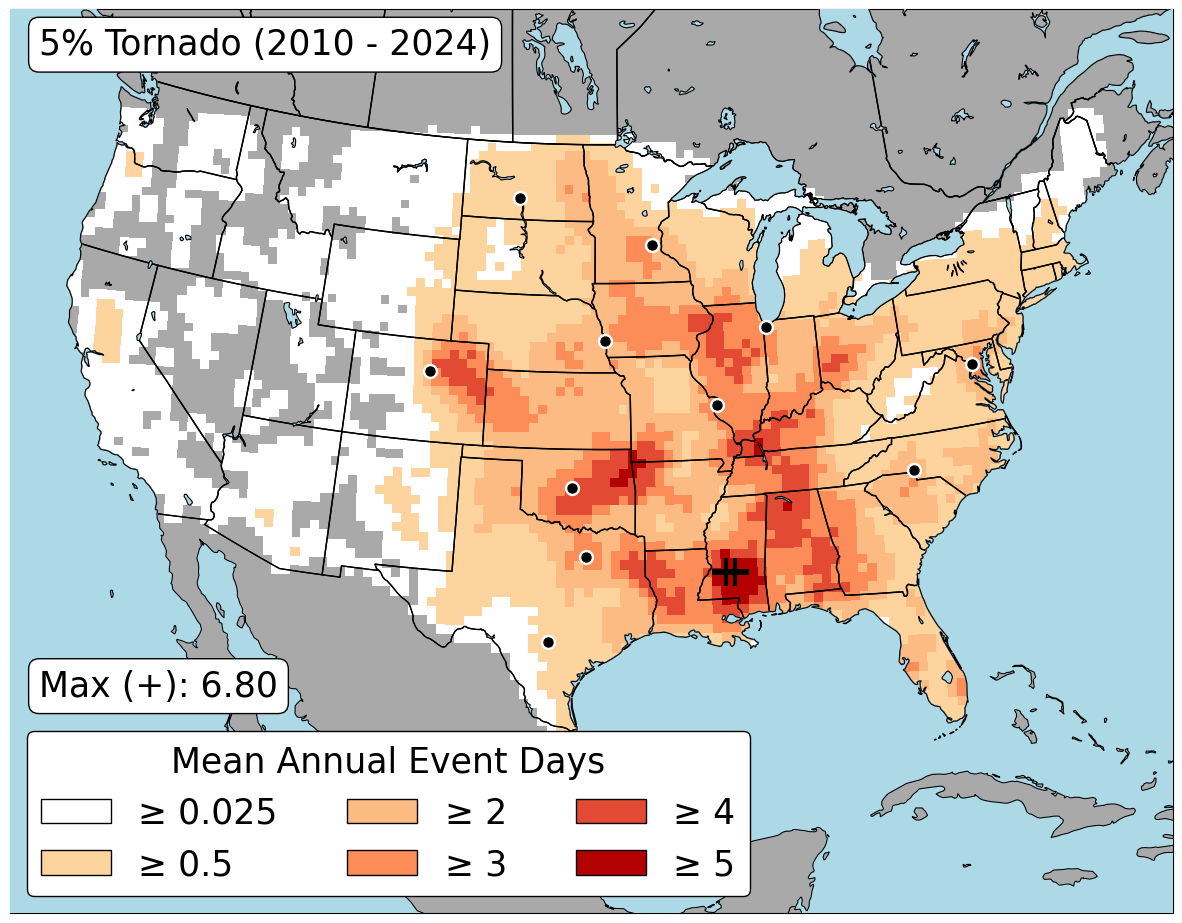

Processing torn at 10.0% severity...
Processed 2576 days for torn, 15 years
  - NCEI days: 2576
  - NOAA days: 0
Maximum value: 4.600 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/torn_10pct_2010-2024.png


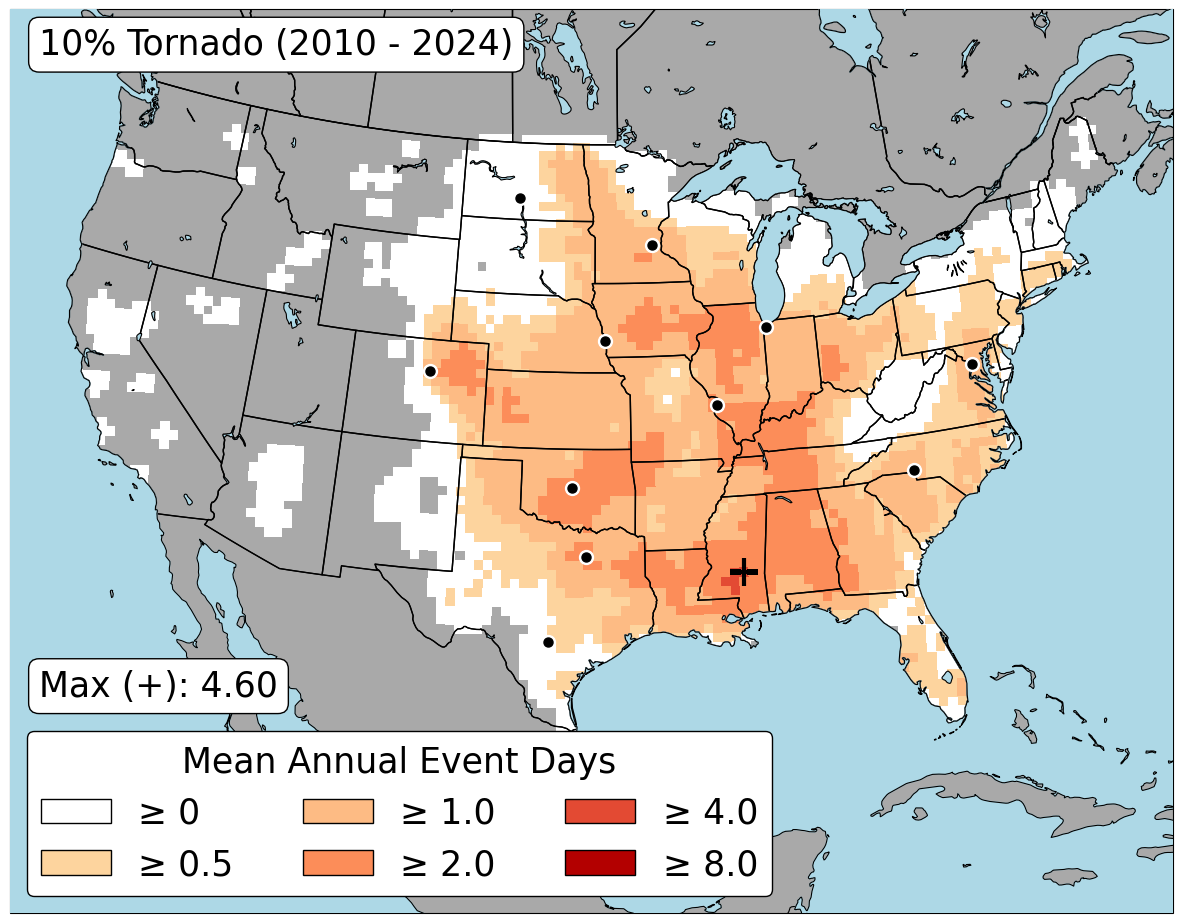

Processing torn at 15.0% severity...
Processed 2576 days for torn, 15 years
  - NCEI days: 2576
  - NOAA days: 0
Maximum value: 3.133 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/torn_15pct_2010-2024.png


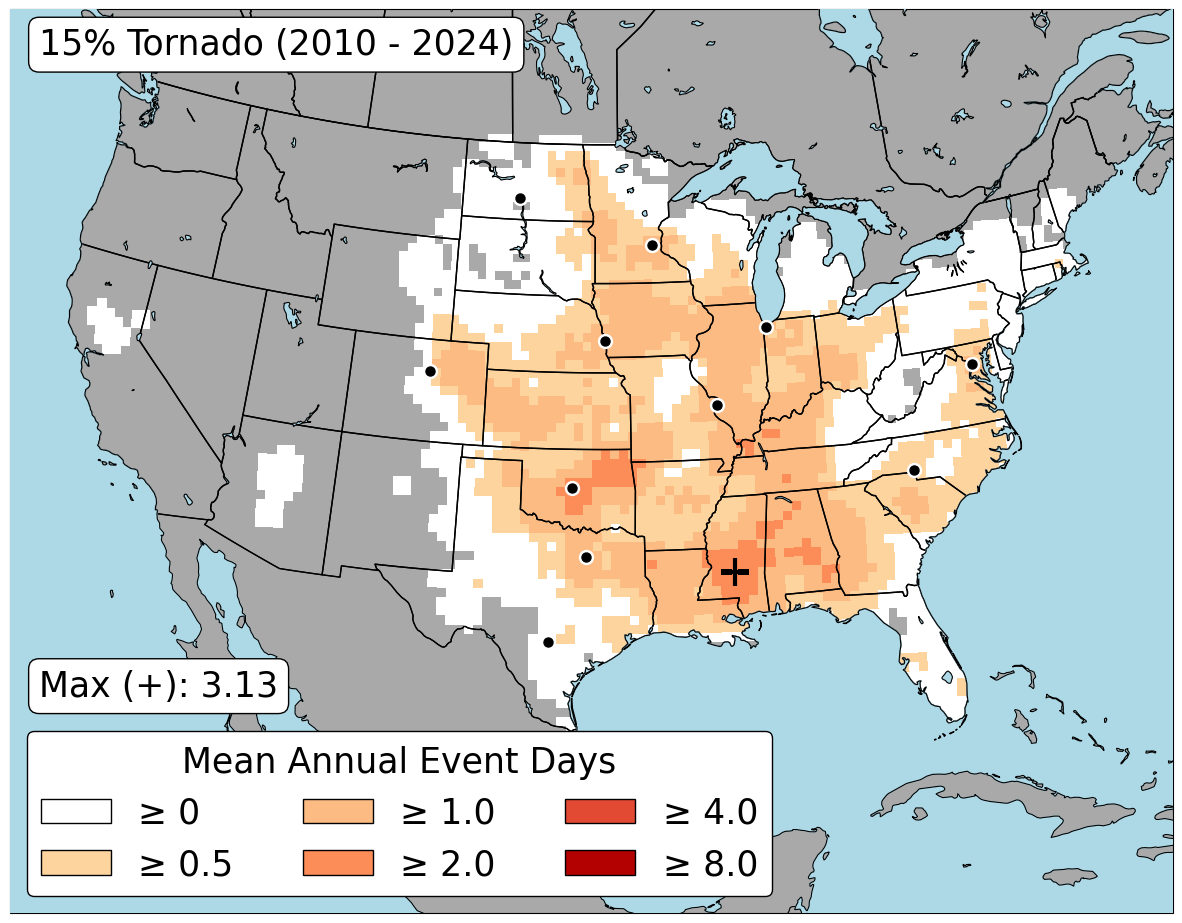

Processing torn at 30.0% severity...
Processed 2576 days for torn, 15 years
  - NCEI days: 2576
  - NOAA days: 0
Maximum value: 1.667 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/torn_30pct_2010-2024.png


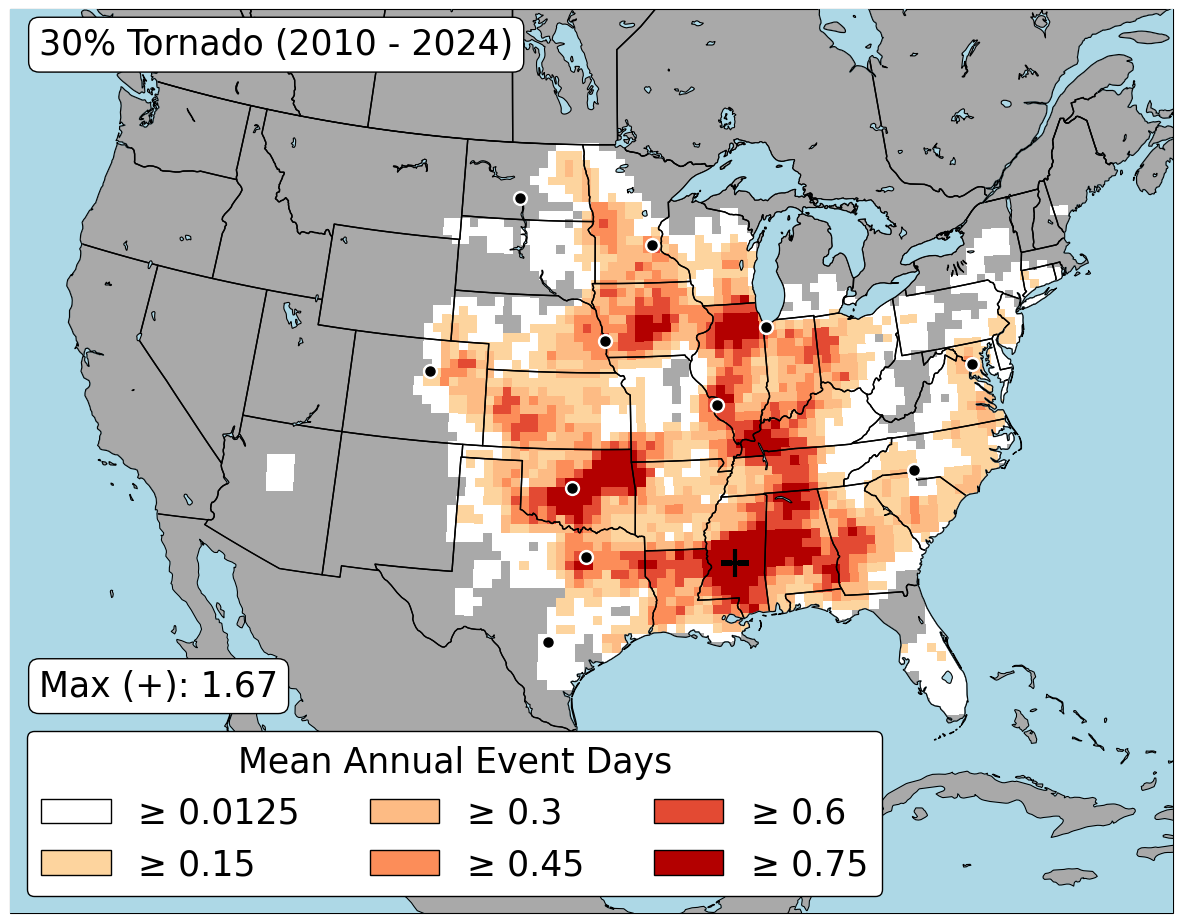

Processing torn at 60.0% severity...
Processed 2576 days for torn, 15 years
  - NCEI days: 2576
  - NOAA days: 0
Maximum value: 0.800 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/torn_60pct_2010-2024.png


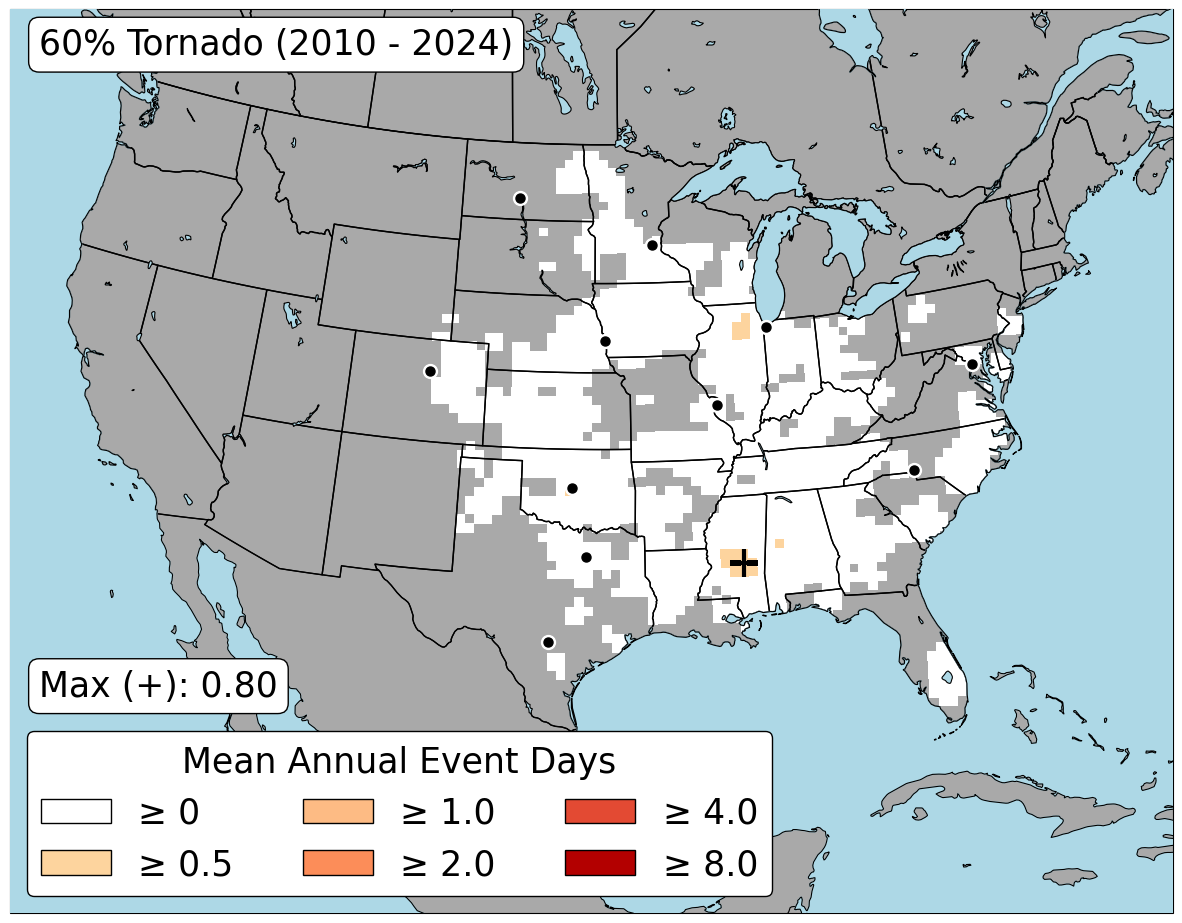

Processing wind at 5.0% severity...
Processed 3704 days for wind, 15 years
  - NCEI days: 3704
  - NOAA days: 0
Maximum value: 38.200 at 2 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/wind_5pct_2010-2024.png


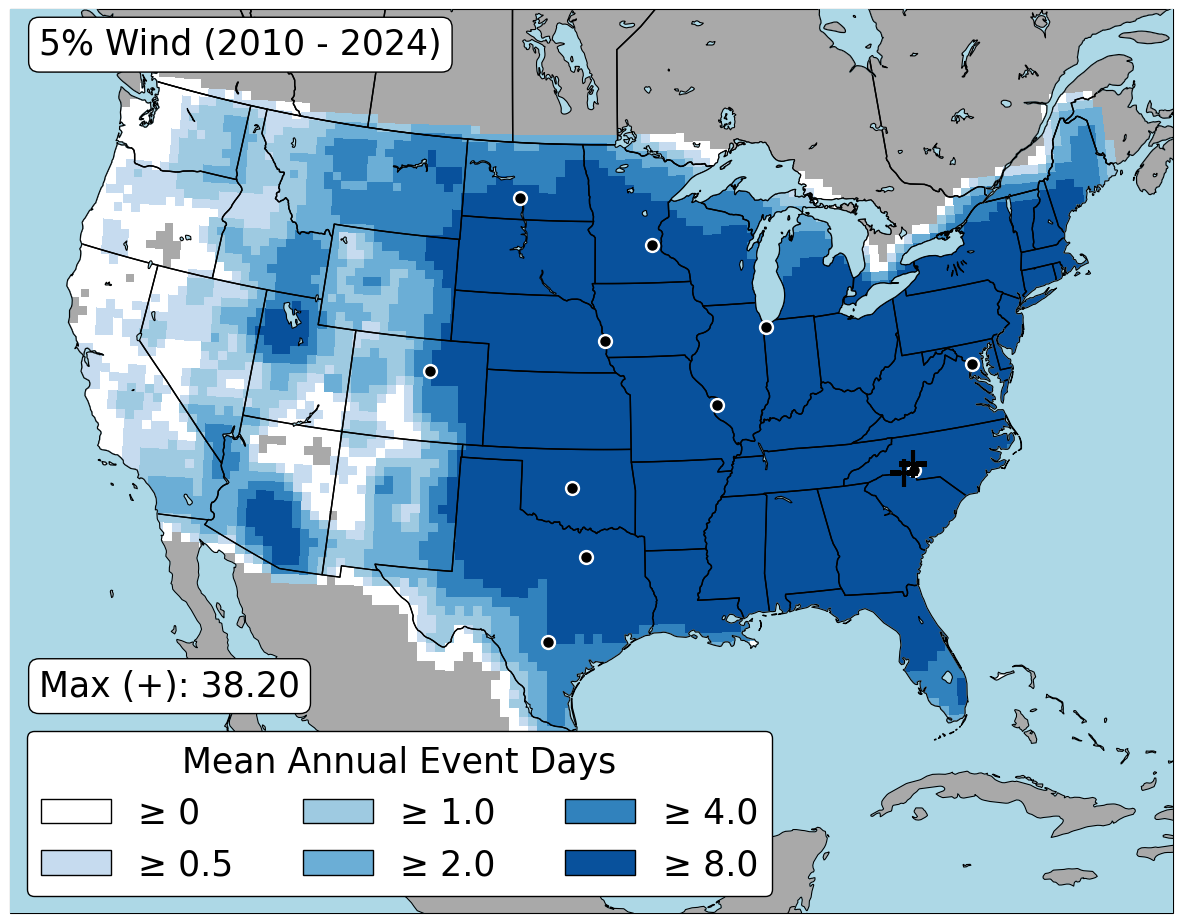

Processing wind at 10.0% severity...
Processed 3704 days for wind, 15 years
  - NCEI days: 3704
  - NOAA days: 0
Maximum value: 30.467 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/wind_10pct_2010-2024.png


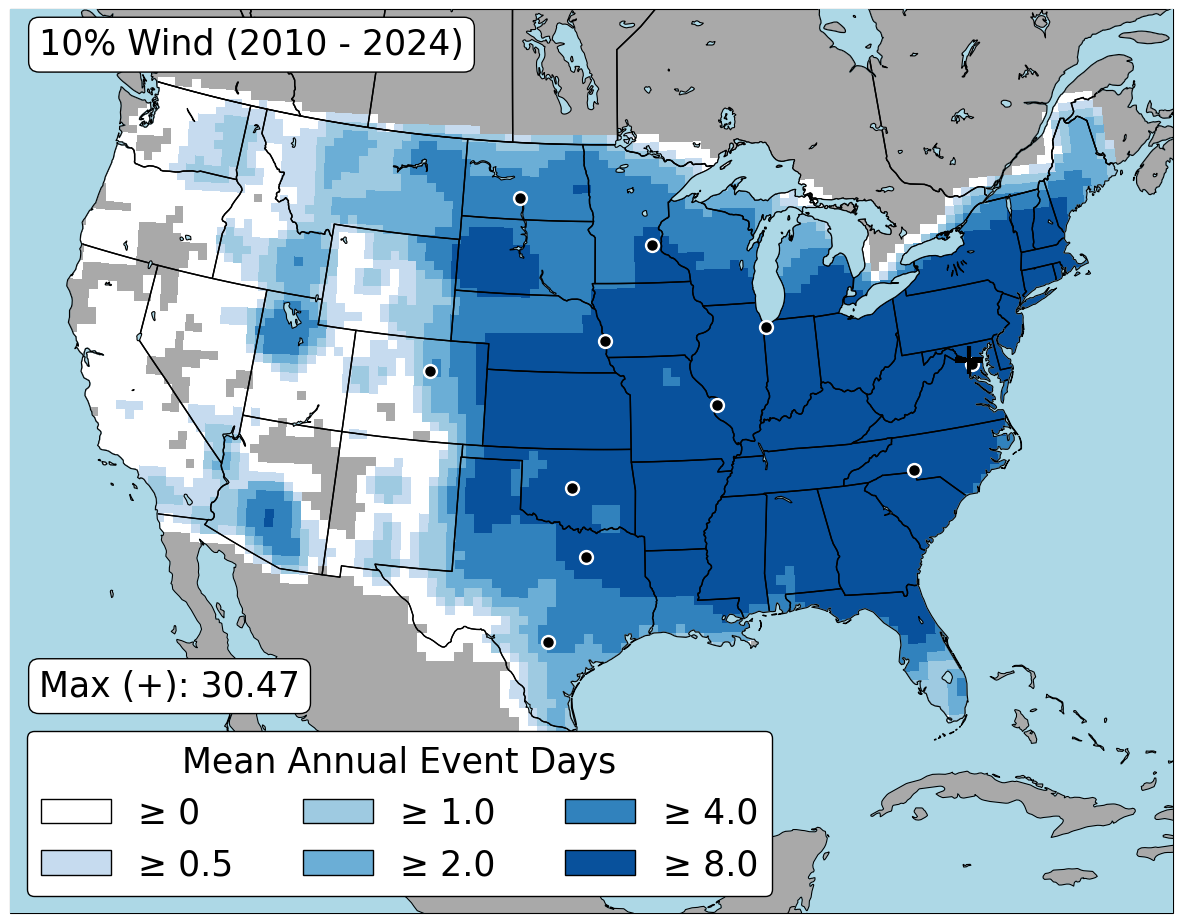

Processing wind at 15.0% severity...
Processed 3704 days for wind, 15 years
  - NCEI days: 3704
  - NOAA days: 0
Maximum value: 26.133 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/wind_15pct_2010-2024.png


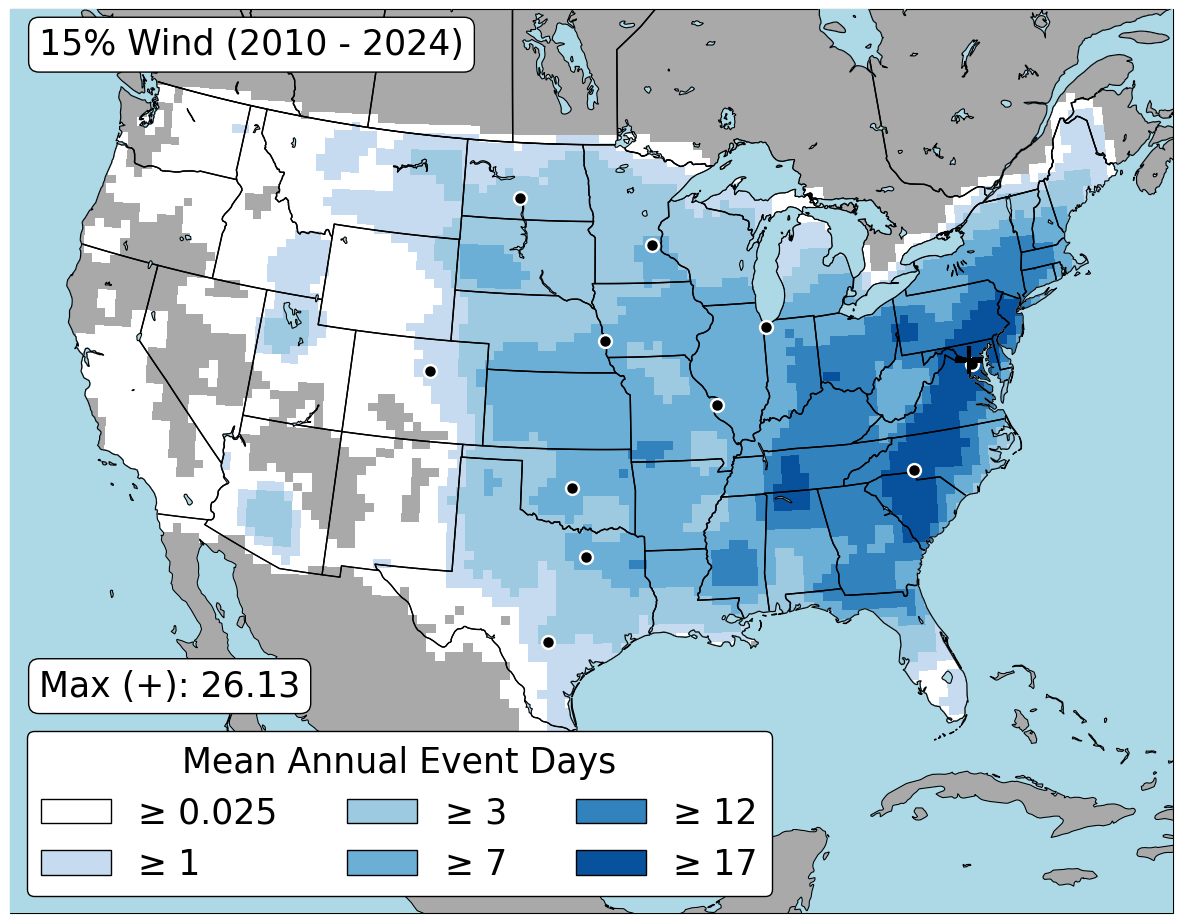

Processing wind at 30.0% severity...
Processed 3704 days for wind, 15 years
  - NCEI days: 3704
  - NOAA days: 0
Maximum value: 18.600 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/wind_30pct_2010-2024.png


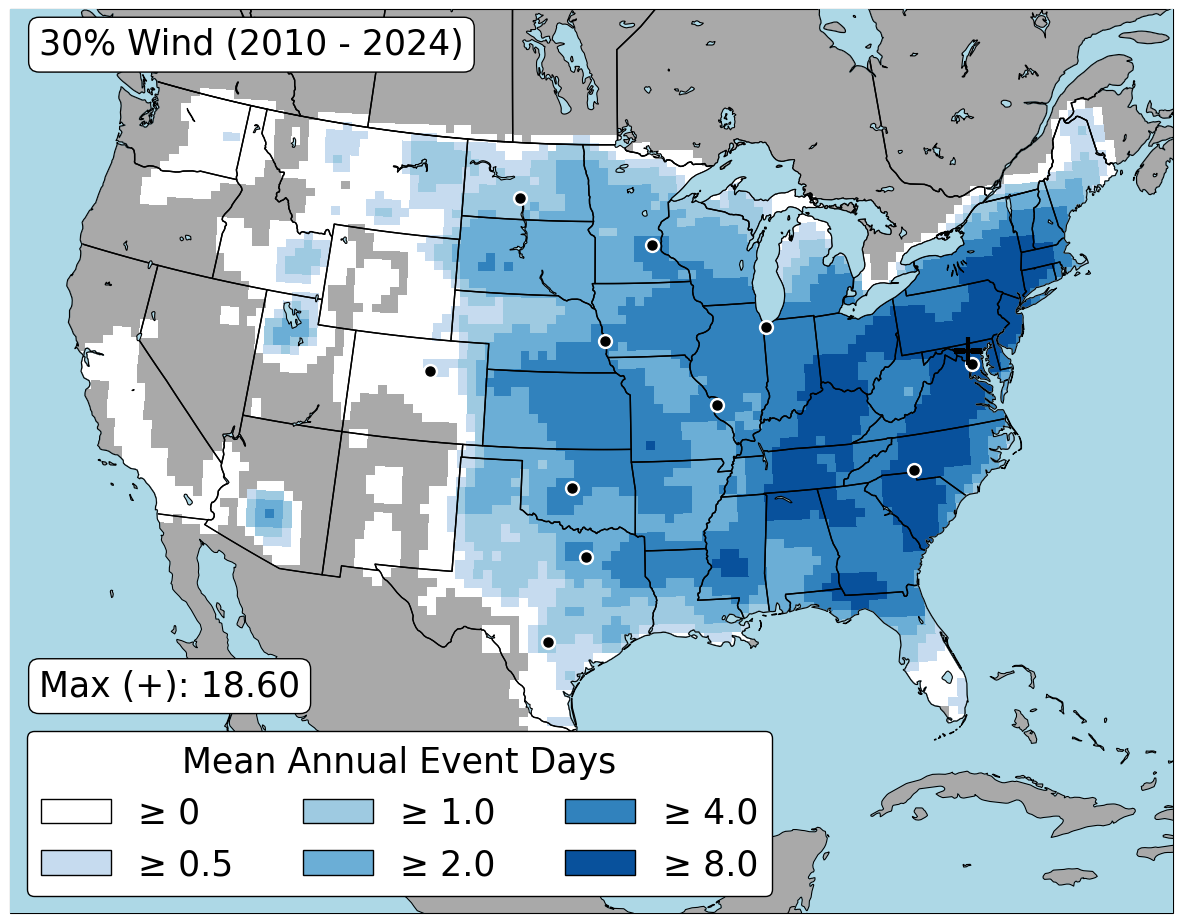

Processing wind at 60.0% severity...
Processed 3704 days for wind, 15 years
  - NCEI days: 3704
  - NOAA days: 0
Maximum value: 12.200 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/wind_60pct_2010-2024.png


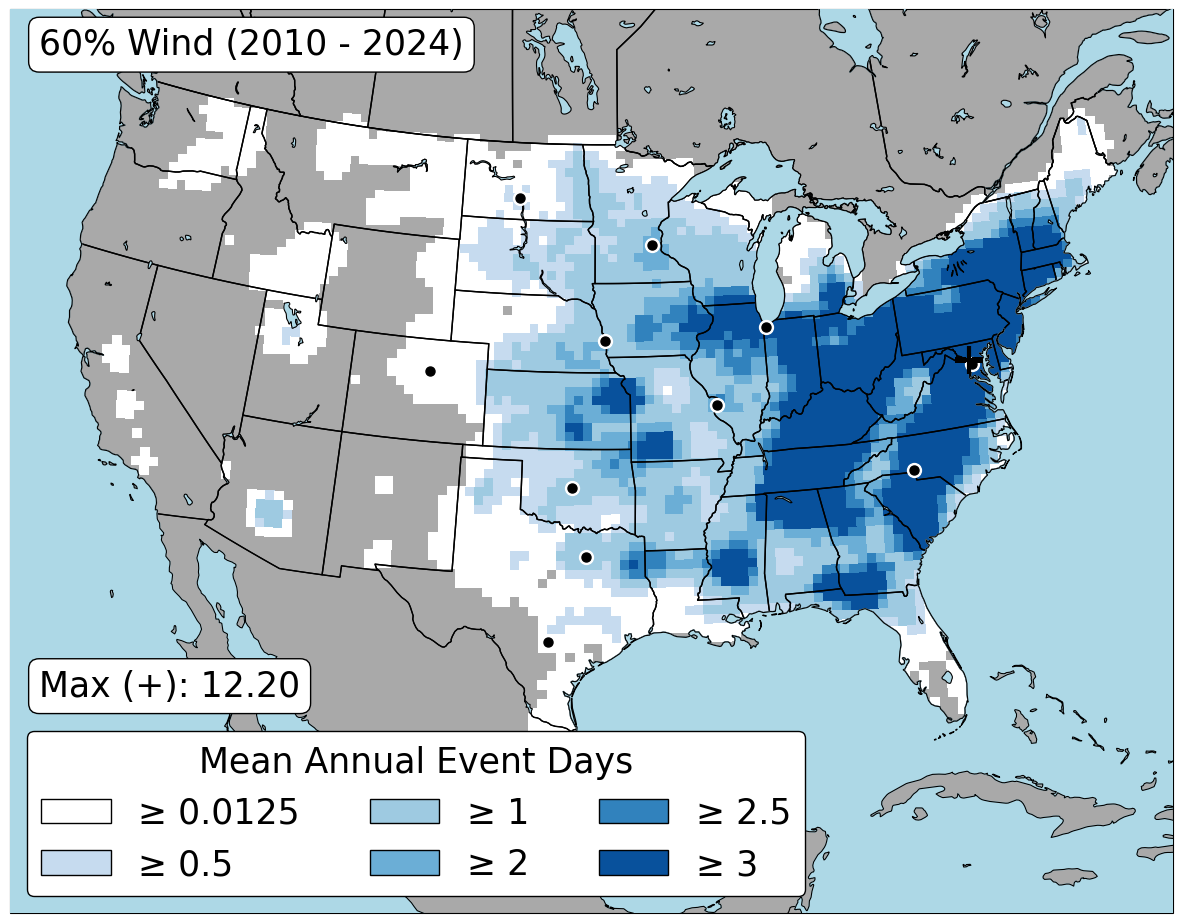

Processing hail at 5.0% severity...
Processed 3465 days for hail, 15 years
  - NCEI days: 3465
  - NOAA days: 0
Maximum value: 25.867 at 2 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/hail_5pct_2010-2024.png


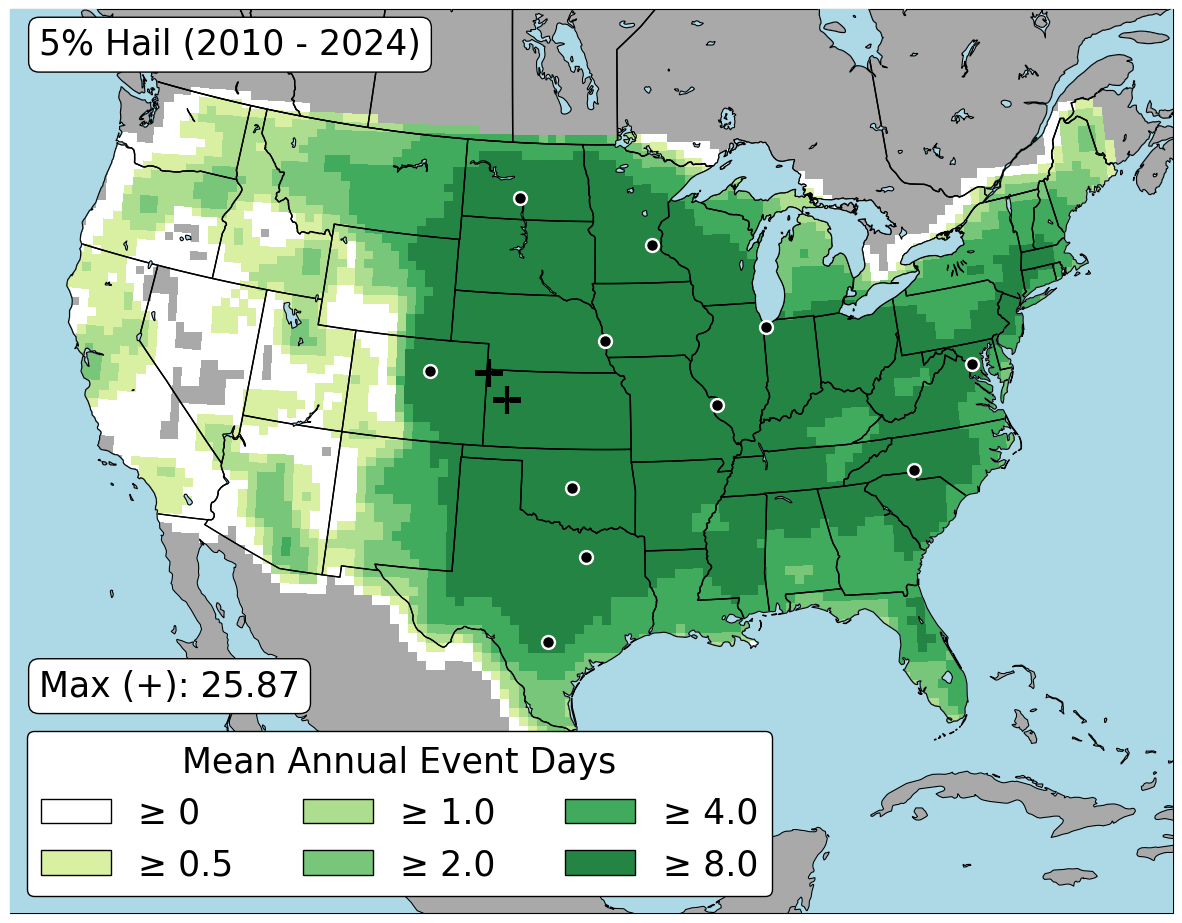

Processing hail at 10.0% severity...
Processed 3465 days for hail, 15 years
  - NCEI days: 3465
  - NOAA days: 0
Maximum value: 20.000 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/hail_10pct_2010-2024.png


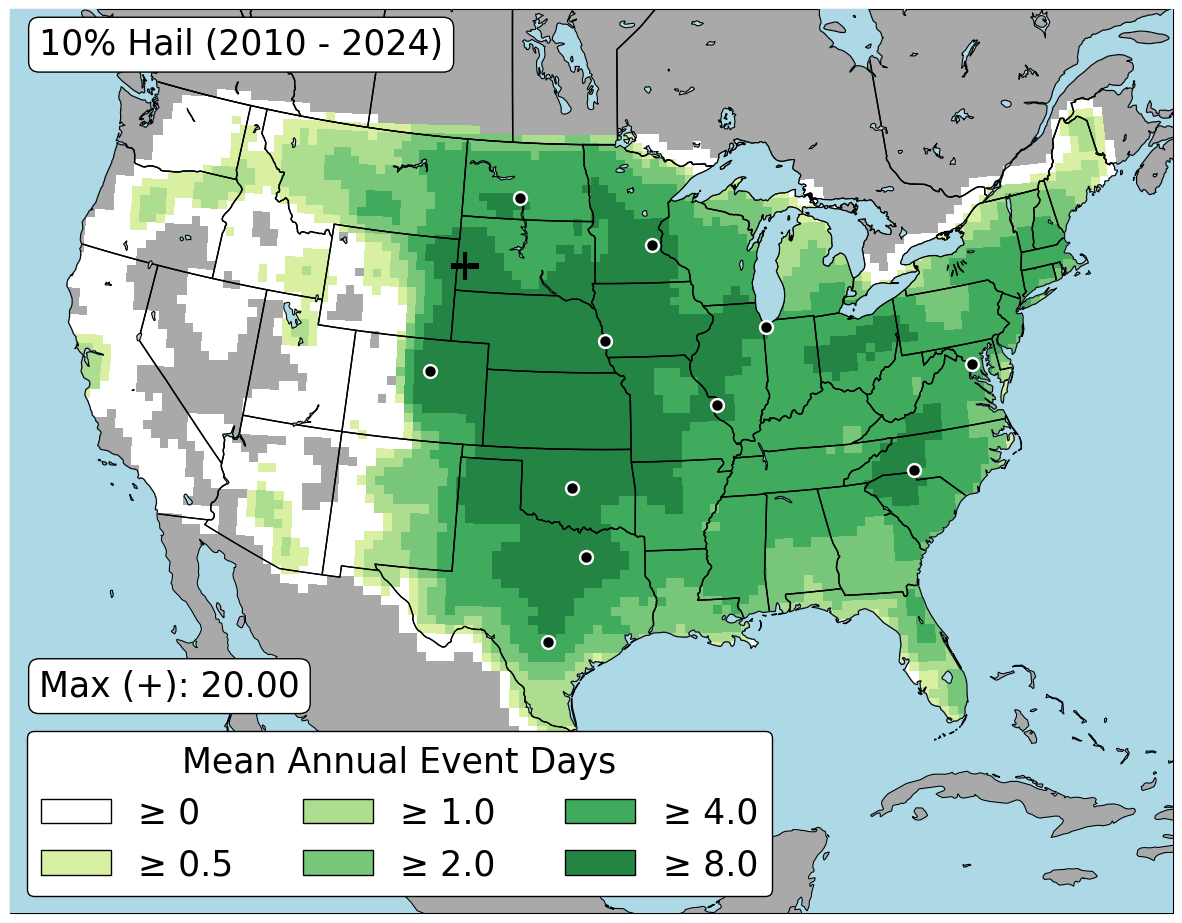

Processing hail at 15.0% severity...
Processed 3465 days for hail, 15 years
  - NCEI days: 3465
  - NOAA days: 0
Maximum value: 16.533 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/hail_15pct_2010-2024.png


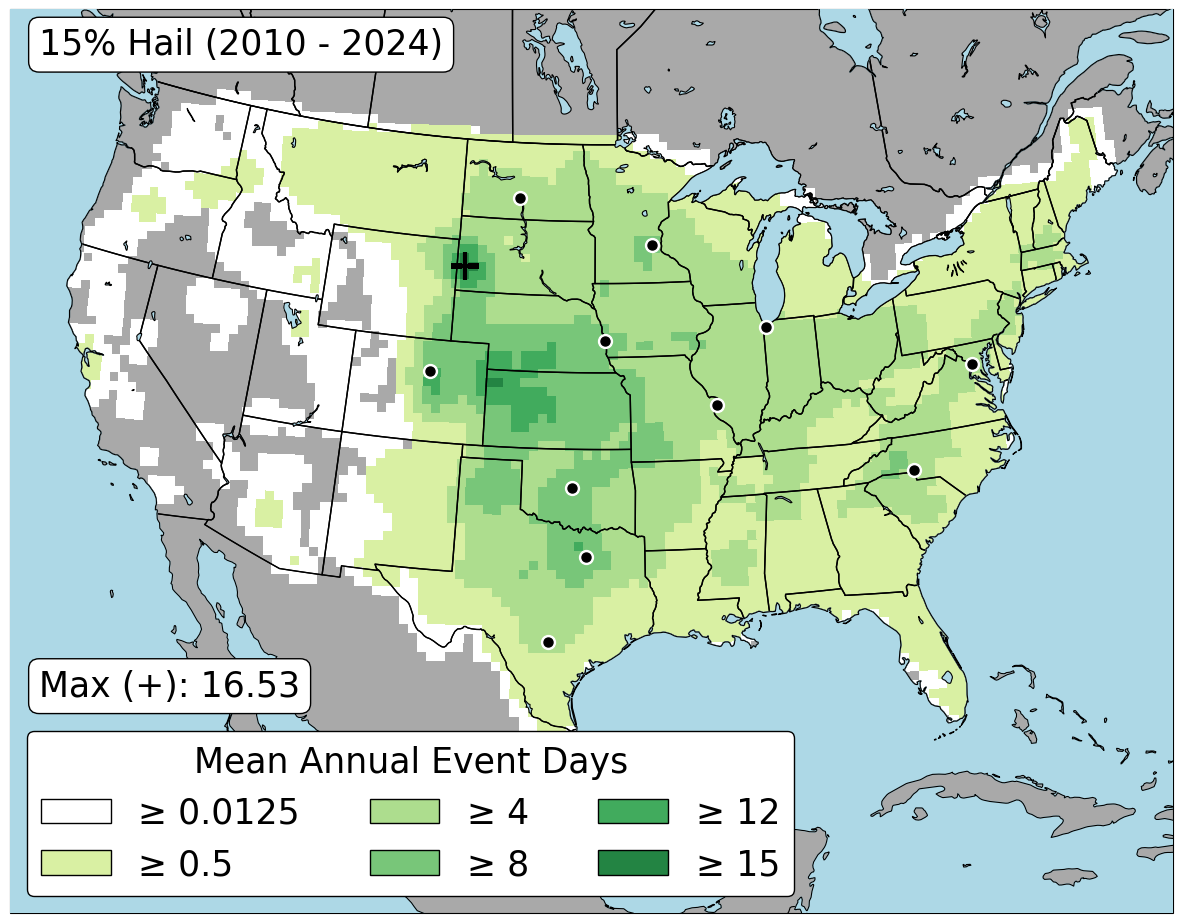

Processing hail at 30.0% severity...
Processed 3465 days for hail, 15 years
  - NCEI days: 3465
  - NOAA days: 0
Maximum value: 9.667 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/hail_30pct_2010-2024.png


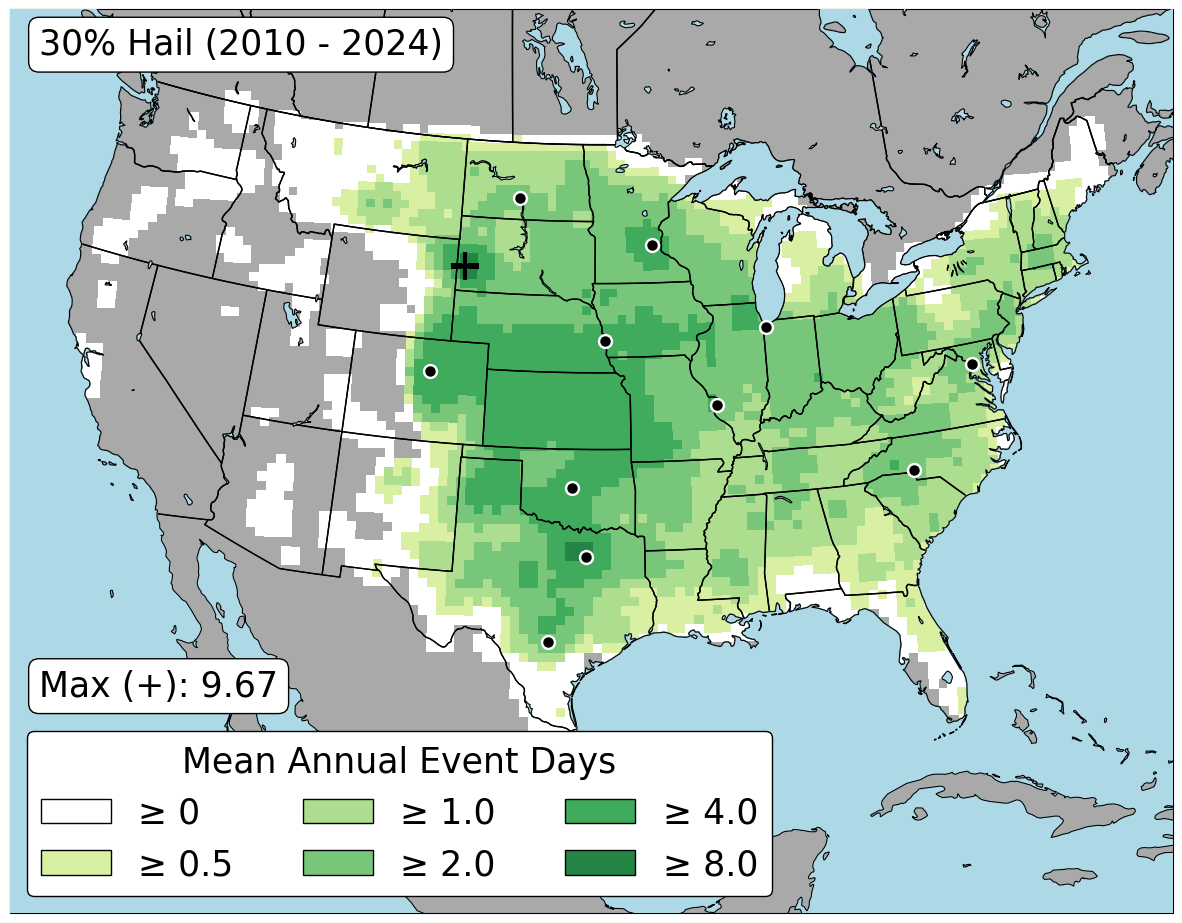

Processing hail at 60.0% severity...
Processed 3465 days for hail, 15 years
  - NCEI days: 3465
  - NOAA days: 0
Maximum value: 5.400 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated/hail_60pct_2010-2024.png


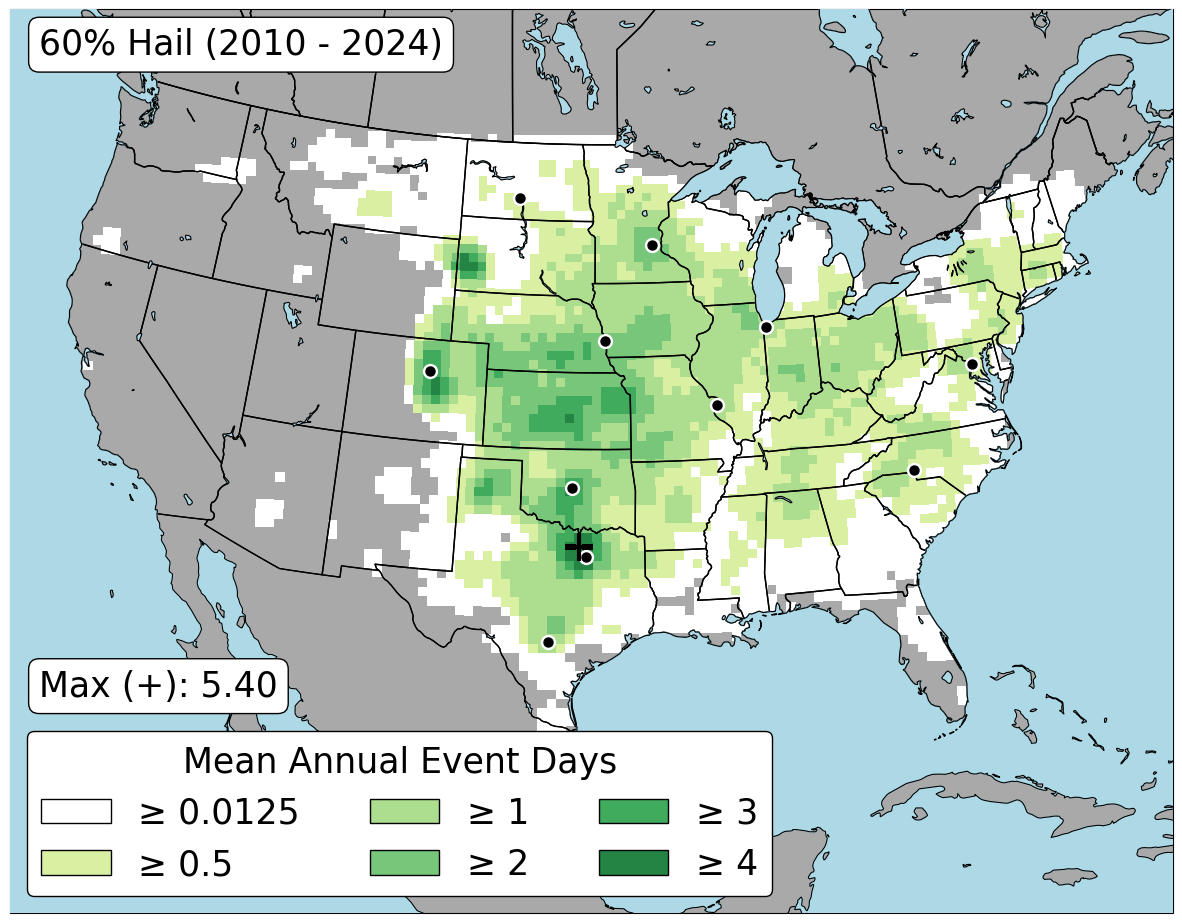

In [15]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"Code graphs PPH for both noaa and ncei and attempts to replicate "
"Practically Perfect Hindcasts of Severe Convective Storms  visualizations"

"We use NCEI up until year 2024, and then 2025 onwards we use NOAA"

"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climo'

"Before running, you must have adjusted the following "
"1) set the correct path for the grid spacing file (grid_ds)"
"2) Adjust file name for ncei_pph_namXXX output file in get_data_path function" 
"3) Adjust file name for noaa_pph_namXXX output file in get_data_path function"
"4) Adjust 'scales' in plot_pph_analysis function"

# Load your desired grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Years to analyze 
start_year = 2010 # Starts in January of this year
end_year = 2024 # Ends in December of this year

#Adjust file names to match your grid size
def get_data_path(storm_type, year, month, day):
    if year <= 2024:
        return f"/Users/jimnguyen/IRMII/SCS_API/PPH/NCEI_PPH/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"
    else:  # year >= 2025
        return f"noaa_pph_outputs/noaa_pph_nam212/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"

# Choose if "slight" or "moderate"
storm_configs = {
    'torn': [0.05, 0.10, 0.15, 0.30, 0.60],    # .05 = slight, .3 = moderate
    'wind': [0.05, 0.10, 0.15, 0.30, 0.60],    # .15 = slight, .6 = moderate
    'hail': [0.05, 0.10, 0.15, 0.30, 0.60]     # .15 = slight, .6 = moderate
}

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities plotted
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Dallas, TX': (-96.7977, 32.7815),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Chicago ,IL' : (-87.3954, 41.520480),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)

    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    ncei_days = 0
    noaa_days = 0
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = get_data_path(storm_type, year, month, day)
        
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
            # Tracking if NCEI or NOAA
            if year <= 2024:
                ncei_days += 1
            else:
                noaa_days += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    print(f"  - NCEI days: {ncei_days}")
    print(f"  - NOAA days: {noaa_days}")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs):
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'torn': ['#ffffff','#fdd49e','#fdbb84','#fc8d59','#e34a33','#b30000'],
        'hail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
        'wind': ['#ffffff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
    }
    
    # Adjust scales depending on your grid type. 
    # Currently below is grid sizes for NAM212 40km 
    scales = {
        'torn': {
            0.05: [0.025, .5, 2, 3, 4, 5, 100],
            0.30: [0.0125, 0.15, .3, .45, .6, .75, 100]
        },
        'hail': {
            0.15:  [0.0125, .5, 4, 8, 12, 15, 100],
            0.60: [0.0125, .5, 1, 2, 3, 4, 100]

        },
        'wind': {
            0.15:  [0.025, 1, 3, 7, 12, 17, 100],
            0.60: [0.0125, .5, 1, 2, 2.5, 3, 100]
        }
    }

    storm_names = {
        'torn': 'Tornado',
        'hail': 'Hail', 
        'wind': 'Wind'
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)


                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                
                output_dir = f"/Users/jimnguyen/IRMII/SCS_API/PPH/Mean_Annual_Event_Days_Graphs_Updated"
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                else:
                    print("Output dir already exists")
                    
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
            
                print(f"Saved: {filepath}")

                plt.show()
                
                plt.close()
                
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

# For SIG HAIL only PPH

In [29]:
"""
Generate PPH for annual NCEI_storm_reports
Remember to run the latlong filter script first
Honestly could've been done with the single CSV file but I'm too lazy to change previous code

Code adapted for NOAA Storm Reports format"
Processing Storm_Reports_YYYY_latlong.csv files from 1950-2024
"""

import numpy as np
import os
import pandas as pd
import xarray as xr


sigma_grid_units = 1.5
grid_spacing_km = 40.0   

# Download and Load NAM-212 grid 
url = 'https://github.com/ahaberlie/PPer_Climo/tree/master/data'
try:
    grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
    grid212_lat = grid_ds["gridlat_212"].values  # (ny, nx)
    grid212_lon = grid_ds["gridlon_212"].values  # (ny, nx)
    print(f"Loaded grid with shape: {grid212_lat.shape}")
except Exception as e:
    print(f"Error loading grid file: {e}")
    exit(1)

# Storm type mapping from EVENT_TYPE
storm_types = {"Hail": "sighail"}

# Distance function for PPH
def euclidean_distance_km(grid_lat, grid_lon, report_lat, report_lon):
    lat_km = 111.32 * (grid_lat - report_lat)
    lon_km = 111.32 * np.cos(np.radians(report_lat)) * (grid_lon - report_lon)
    return np.sqrt(lat_km**2 + lon_km**2)

# Create output directory
output_folder = "SIG_Hail_PPH"
os.makedirs(output_folder, exist_ok=True)

# Create output subfolders for each storm type
for storm_type in storm_types.values():
    output_subfolder = os.path.join(output_folder, storm_type)
    os.makedirs(output_subfolder, exist_ok=True)

# Process each year from 2010-2024
for year in range(2009, 2025):  #2010 to 2024 inclusive
    file_path = f"/USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/sig_hail_filtered/Hail_Reports_SIG_{year}.csv"
    #change to your filepath
    if not os.path.exists(file_path):
        print(f"File does not exist: {file_path}")
        continue

    try:
        print(f"\nProcessing {file_path}...")
        
        # Read the data
        data = pd.read_csv(file_path)
        
        # Clean and convert data types
        data['BEGIN_LAT'] = pd.to_numeric(data['BEGIN_LAT'], errors='coerce')
        data['BEGIN_LON'] = pd.to_numeric(data['BEGIN_LON'], errors='coerce')
        data['BEGIN_DAY'] = pd.to_numeric(data['BEGIN_DAY'], errors='coerce')
        data['MONTH_NUM'] = pd.to_numeric(data['MONTH_NUM'], errors='coerce')
        
        # Remove rows with missing critical data
        initial_count = len(data)
        data = data.dropna(subset=['BEGIN_LAT', 'BEGIN_LON', 'BEGIN_DAY', 'MONTH_NUM', 'EVENT_TYPE'])
        if len(data) < initial_count:
            print(f"  Removed {initial_count - len(data)} rows with missing data")

        # Filter to CONUS bounds
        conus_data = data[(data['BEGIN_LAT'] >= 24.52) & (data['BEGIN_LAT'] <= 49.385) &
                         (data['BEGIN_LON'] >= -124.74) & (data['BEGIN_LON'] <= -66.95)]

        if len(conus_data) < len(data):
            print(f"  Filtered {len(data) - len(conus_data)} reports outside CONUS")
        
        data = conus_data

        if len(data) == 0:
            print(f"  No valid data for {year}")
            continue

        # Process each storm type
        for event_type, storm_type in storm_types.items():
            print(f"  Processing {event_type} reports...")
            
            # Filter data for this storm type
            storm_data = data[data['EVENT_TYPE'] == event_type].copy()
            
            if len(storm_data) == 0:
                print(f"    No {event_type} reports for {year}")
                continue
                
            print(f"    Found {len(storm_data)} {event_type} reports")
            
            # Get output subfolder for this storm type
            output_subfolder = os.path.join(output_folder, storm_type)
            
            # Process each month
            for month in range(1, 13):
                month_data = storm_data[storm_data['MONTH_NUM'] == month].copy()
                
                if len(month_data) == 0:
                    continue
                
                # Process each day in the month
                for day in sorted(month_data['BEGIN_DAY'].unique()):
                    day_data = month_data[month_data['BEGIN_DAY'] == day]
                    
                    if len(day_data) == 0:
                        continue
                    
                    # Initialize the sum for PPH
                    gaussian_sum = np.zeros_like(grid212_lat, dtype=np.float64)

                    # Compute the PPH 
                    for _, row in day_data.iterrows():
                        d_km = euclidean_distance_km(
                            grid212_lat, grid212_lon,
                            row['BEGIN_LAT'], row['BEGIN_LON']
                        )
                        
                        # Convert to grid units 
                        d_grid = d_km / grid_spacing_km
                        
                        # Summing the Nth terms 
                        gaussian_sum += np.exp(-0.5 * (d_grid / sigma_grid_units) ** 2)

                    # Apply prefactor: (1 / (2π sigma²)) 
                    gauss_pref = 1.0 / (2.0 * np.pi * sigma_grid_units**2)
                    daily_pph = gauss_pref * gaussian_sum
                    rounded_pph = np.round(daily_pph, 10)

                    # Saving
                    file_name_out = f"pph_{year}_{month:02d}_{int(day):02d}.csv"
                    output_file = os.path.join(output_subfolder, file_name_out)

                    try:
                        df = pd.DataFrame(rounded_pph)
                        df.to_csv(output_file, index=False)
                        
                        print(f"    Calculated PPH for {storm_type} on {year}-{month:02d}-{int(day):02d} ({len(day_data)} reports)")
                        
                    except Exception as e:
                        print(f"    Error saving PPH for {year}-{month:02d}-{int(day):02d}: {e}")
                        continue

    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        continue

print("\nNOAA Storm Reports PPH processing complete!")

Loaded grid with shape: (129, 185)
File does not exist: /USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/sig_hail_filtered/Hail_Reports_SIG_2009.csv

Processing /USERS/jimnguyen/IRMII/SCS_API/NCEI_storm_reports/sig_hail_filtered/Hail_Reports_SIG_2010.csv...
  Processing Hail reports...
    Found 663 Hail reports
    Calculated PPH for sighail on 2010-01-20 (4 reports)
    Calculated PPH for sighail on 2010-01-21 (1 reports)
    Calculated PPH for sighail on 2010-02-21 (1 reports)
    Calculated PPH for sighail on 2010-03-07 (1 reports)
    Calculated PPH for sighail on 2010-03-10 (4 reports)
    Calculated PPH for sighail on 2010-03-12 (4 reports)
    Calculated PPH for sighail on 2010-04-04 (3 reports)
    Calculated PPH for sighail on 2010-04-05 (9 reports)
    Calculated PPH for sighail on 2010-04-06 (7 reports)
    Calculated PPH for sighail on 2010-04-11 (3 reports)
    Calculated PPH for sighail on 2010-04-21 (3 reports)
    Calculated PPH for sighail on 2010-04-22 (10 reports)


Processing sighail at 5.0% severity...
Processed 1776 days for sighail, 15 years
  - NCEI days: 1776
  - NOAA days: 0
Maximum value: 5.467 at 2 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_5pct_2010-2024.png


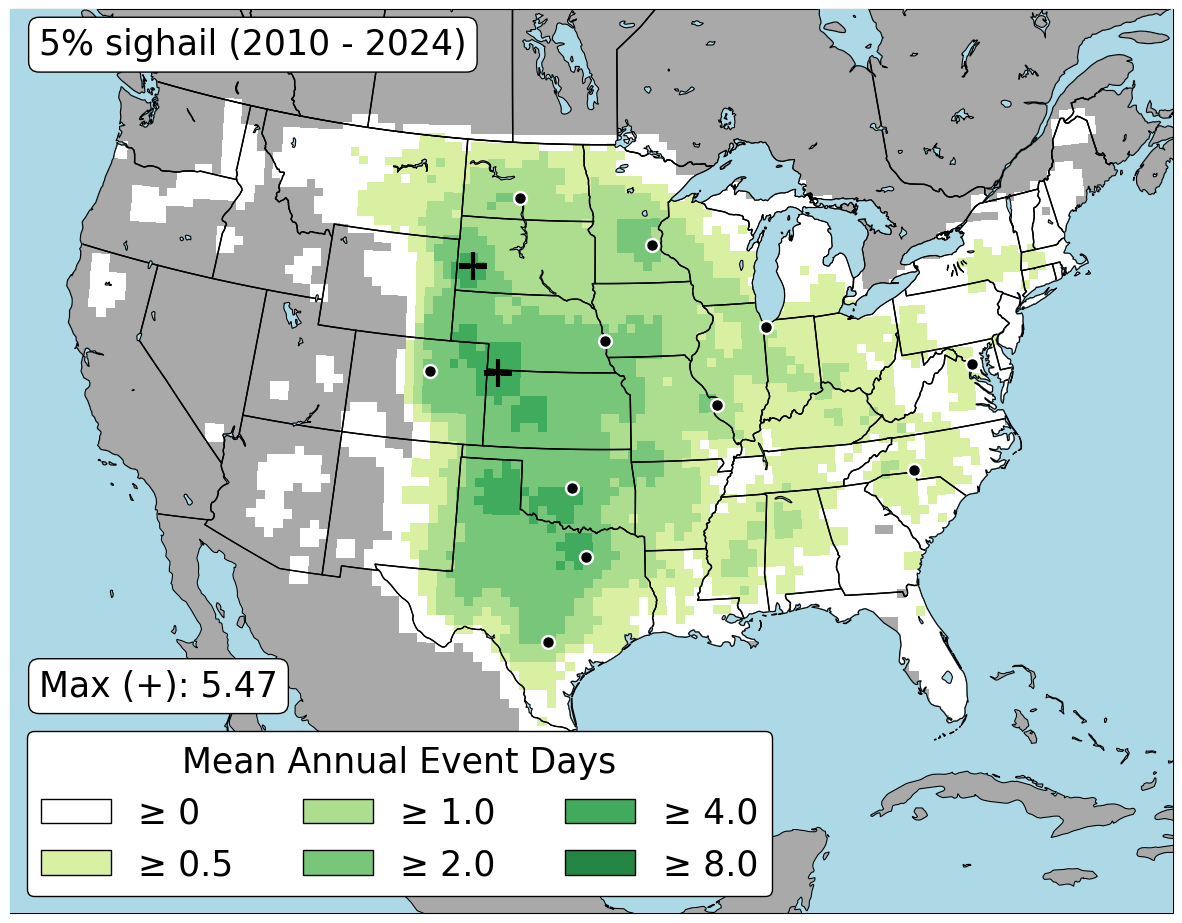

Processing sighail at 10.0% severity...
Processed 1776 days for sighail, 15 years
  - NCEI days: 1776
  - NOAA days: 0
Maximum value: 3.333 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_10pct_2010-2024.png


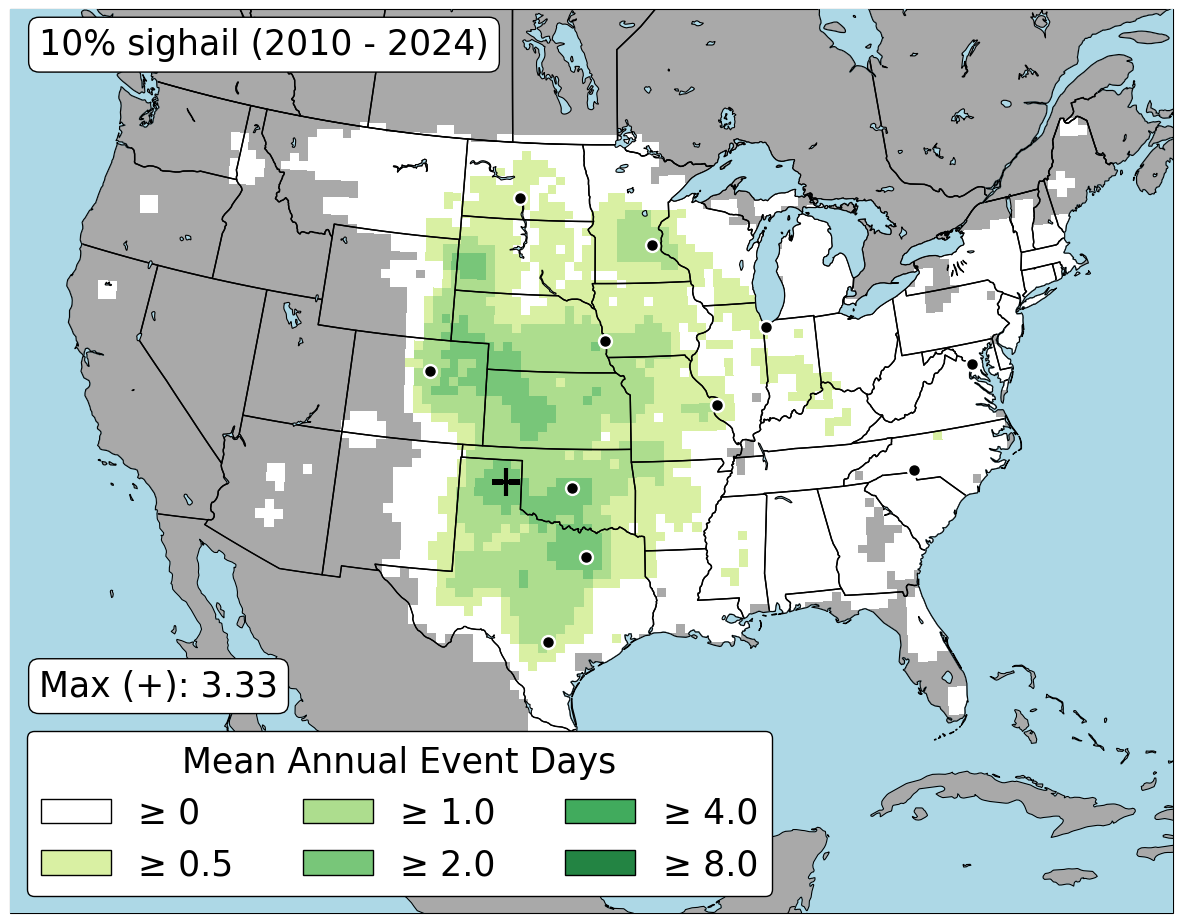

Processing sighail at 15.0% severity...
Processed 1776 days for sighail, 15 years
  - NCEI days: 1776
  - NOAA days: 0
Maximum value: 2.400 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_15pct_2010-2024.png


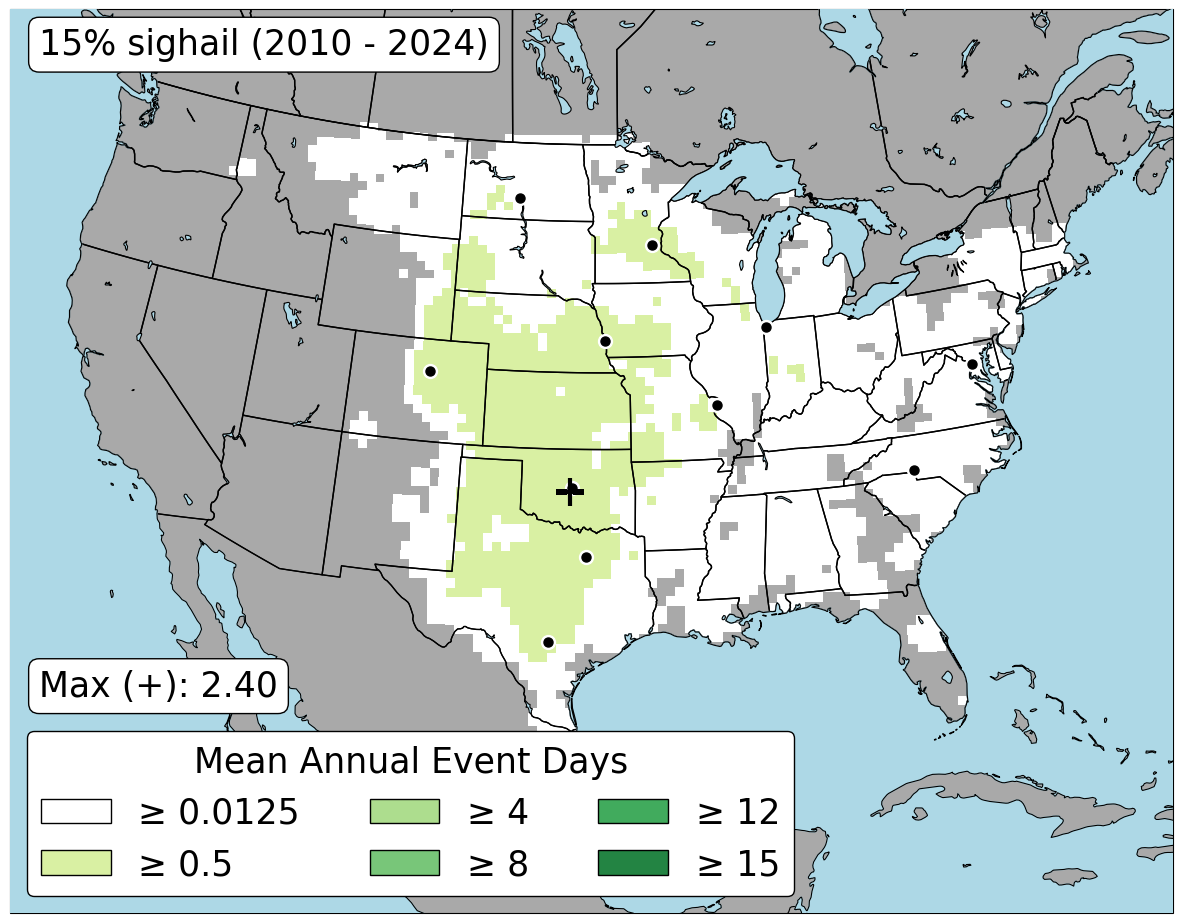

Processing sighail at 30.0% severity...
Processed 1776 days for sighail, 15 years
  - NCEI days: 1776
  - NOAA days: 0
Maximum value: 1.467 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_30pct_2010-2024.png


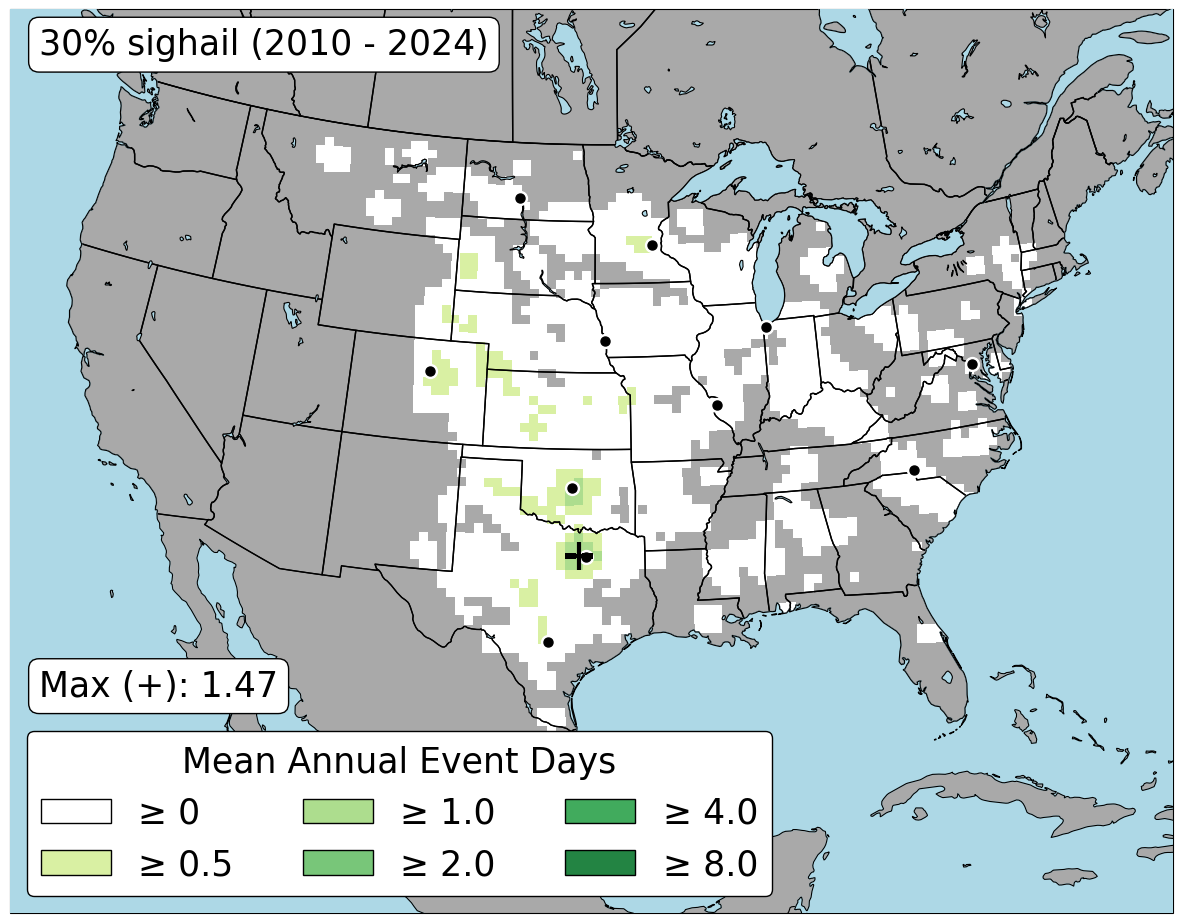

Processing sighail at 60.0% severity...
Processed 1776 days for sighail, 15 years
  - NCEI days: 1776
  - NOAA days: 0
Maximum value: 0.867 at 1 locations
Output dir already exists
Saved: /Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs/sighail_60pct_2010-2024.png


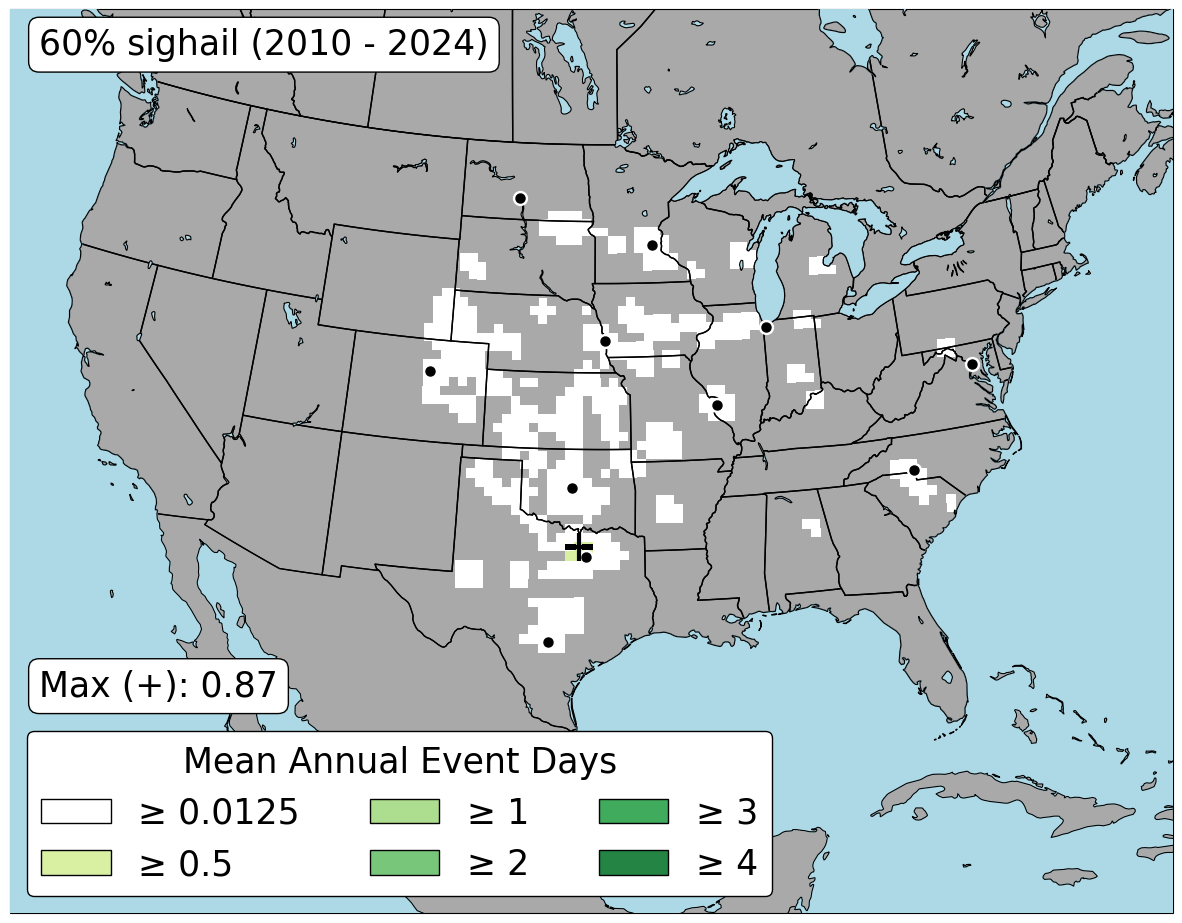

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm, ListedColormap

"Code graphs PPH for both noaa and ncei and attempts to replicate "
"Practically Perfect Hindcasts of Severe Convective Storms  visualizations"

"We use NCEI up until year 2024, and then 2025 onwards we use NOAA"

"All credit to the original research paper and its code can be found here"
url = 'https://github.com/ahaberlie/PPer_Climo'

"Before running, you must have adjusted the following "
"1) set the correct path for the grid spacing file (grid_ds)"
"2) Adjust file name for ncei_pph_namXXX output file in get_data_path function" 
"3) Adjust file name for noaa_pph_namXXX output file in get_data_path function"
"4) Adjust 'scales' in plot_pph_analysis function"

# Load your desired grid coordinates
grid_ds = xr.open_dataset("/Users/jimnguyen/IRMII/SCS_API/PPH/nam212.nc") #Set to your folder pathway
lats = grid_ds["gridlat_212"].values
lons = grid_ds["gridlon_212"].values

# Years to analyze 
start_year = 2010 # Starts in January of this year
end_year = 2024 # Ends in December of this year

#Adjust file names to match your grid size
def get_data_path(storm_type, year, month, day):
    if year <= 2024:
        return f"/Users/jimnguyen/IRMII/SCS_API/PPH/SIG_Hail_PPH/sighail/pph_{year}_{month:02d}_{day:02d}.csv"
    else:  # year >= 2025
        return f"noaa_pph_outputs/noaa_pph_nam212/{storm_type}/pph_{year}_{month:02d}_{day:02d}.csv"

# Choose if "slight" or "moderate"
storm_configs = {
    'sighail': [0.05, 0.10, 0.15, 0.30, 0.60]     # .15 = slight, .6 = moderate
}

# Use Albers Equal Area projection
from_proj = ccrs.PlateCarree()
projection = ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=37.5, false_easting=0.0, 
                                 false_northing=0.0, standard_parallels=(29.5, 45.5), globe=None)

# Cities plotted
cities = {'Denver, CO': (-104.9903, 39.7392),
        'Omaha, NE': (-95.9345, 41.2565),
        'Charlotte, NC': (-80.8431, 35.2271),
        'San Antonio, TX': (-98.4936, 29.4241),
        'Dallas, TX': (-96.7977, 32.7815),
        'Oklahoma City, OK': (-97.5164, 35.4676), 
        'St. Louis, MO': (-90.1994, 38.6270),
        'Minneapolis, MN': (-93.2650, 44.9778), 
        'Bismarck, ND': (-100.773703, 46.801942),
        'Chicago ,IL' : (-87.3954, 41.520480),
        'Washington, DC': (-77.0369, 38.9072)}

# Maps America
def draw_geography(ax):
    """Add geographic features to the map"""
    ax.add_feature(cfeature.OCEAN, color='lightblue', zorder=9)
    ax.add_feature(cfeature.LAND, color='darkgray', zorder=2)

    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black', zorder=8)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.8, zorder=9)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), facecolor='lightblue', edgecolor='black', linewidth=0.8,zorder=9)
    return ax

# Creates the key 
def generate_legend(ax, title, bounds, colors, fontsize=13, propsize=13):
    legend_handles = []
    
    for i in range(len(bounds)):
        label = bounds[i]
        patch = Patch(facecolor=colors[i], edgecolor='k', label=label)
        legend_handles.append(patch)
    
    cax = ax.legend(handles=legend_handles, framealpha=1, title=title, 
                   prop={'size': propsize}, ncol=3, loc=3)
    cax.set_zorder(10)
    cax.get_frame().set_edgecolor('k')
    cax.get_title().set_fontsize('{}'.format(fontsize))
    
    return ax

# Visualizes the PPHs
def draw_pper_map(pper_subset, map_title, map_color_scale, map_colors):
    cmap = ListedColormap(map_colors)
    norm = BoundaryNorm(map_color_scale, ncolors=cmap.N)
    
    ax = plt.subplot(1, 1, 1, projection=projection)
    ax.set_extent([-120, -73, 18.5, 52.5], crs=from_proj)
    ax = draw_geography(ax)
    
    # Create CONUS mask - values outside CONUS will be masked
    conus_mask = ((lats >= 24.52) & (lats <= 49.385) & 
                  (lons >= -124.74) & (lons <= -66.95))
    
    # Mask both zero values AND values outside CONUS
    res = np.ma.masked_where((pper_subset.values == 0) | (~conus_mask), pper_subset.values)
    
    mmp = ax.pcolormesh(lons, lats, res, zorder=6, 
                       cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    
    # Add state lines above the data
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=1.0, edgecolor='black', zorder=7)
    
    labels = []
    for i in range(len(map_color_scale)-1):
        val1 = map_color_scale[i]
        labels.append("≥ {}".format(val1))
    
    legend_handles = generate_legend(ax, map_title, labels, map_colors, fontsize=25, propsize=25)
    
    return ax

# Calculates the mean annual event days
def calculate_mean_annual_days(storm_type, severity, start_year, end_year):
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    days_processed = 0 
    total_days_above_threshold = None
    ncei_days = 0
    noaa_days = 0
    
    current_date = start_date 
    while current_date <= end_date:
        year = current_date.year
        month = current_date.month
        day = current_date.day

        csv_path = get_data_path(storm_type, year, month, day)
        
        if not os.path.exists(csv_path):
            current_date += timedelta(days=1)
            continue

        try:
            df = pd.read_csv(csv_path)       
            pph_daily = (df.values >= severity).astype(int)

            if total_days_above_threshold is None:
                total_days_above_threshold = np.zeros_like(pph_daily)
            
            total_days_above_threshold += pph_daily
            days_processed += 1
            
            # Tracking if NCEI or NOAA
            if year <= 2024:
                ncei_days += 1
            else:
                noaa_days += 1
            
        except Exception as e:
            print(f"Error processing {csv_path}: {e}")
            
        current_date += timedelta(days=1)
    
    if days_processed == 0:
        print(f"No data found for {storm_type} from {start_year} to {end_year}")
        return None
        
    num_years = end_year - start_year + 1
    mean_annual_days = total_days_above_threshold / num_years
    print(f"Processed {days_processed} days for {storm_type}, {num_years} years")
    print(f"  - NCEI days: {ncei_days}")
    print(f"  - NOAA days: {noaa_days}")
    return mean_annual_days

# Main plotting function
def plot_pph_analysis(start_year, end_year, storm_configs):
    
    # Set up figure parameters
    plt.rcParams['figure.figsize'] = 15, 15
    
    # Label positions
    plab_x = .025
    plab_y = .95
    maxlab_x = .025
    maxlab_y = .24
    
    # Color schemes and scales for each storm type
    color_schemes = {
        'sighail': ['#ffffff','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443'],  
    }
    
    # Adjust scales depending on your grid type. 
    # Currently below is grid sizes for NAM212 40km 
    scales = {
        'sighail': {
            0.15:  [0.0125, .5, 4, 8, 12, 15, 100],
            0.60: [0.0125, .5, 1, 2, 3, 4, 100]

        },
    }

    storm_names = {
        'sighail': 'sighail', 
    }
    
    # Process each storm type
    for storm_type, severities in storm_configs.items():
        dy_colors = color_schemes[storm_type]
        
        for severity in severities:
            title = "Mean Annual Event Days"
            name = f"{severity*100:.0f}%"
            key = f'{name} {storm_names[storm_type]}'
            
            # Get appropriate scale
            if severity in scales[storm_type]:
                pper_scale = scales[storm_type][severity]
            else:
                # Fallback scale
                pper_scale = [0, 0.5, 1.0, 2.0, 4.0, 8.0, 100]
            
            print(f"Processing {storm_type} at {severity*100}% severity...")
            data = calculate_mean_annual_days(storm_type, severity, start_year, end_year)
            
            if data is not None:
                dsub = xr.DataArray(data, dims=['y', 'x'])
                
                # Find maximum locations
                max_val = np.nanmax(dsub.values)
                y_max, x_max = np.where(dsub.values == max_val)
                
                print(f"Maximum value: {max_val:.3f} at {len(y_max)} locations")
                
                # Create the map
                fig = plt.figure(figsize=(15, 15))
                ax = draw_pper_map(dsub, title, pper_scale, dy_colors)

                # Mark maximum locations
                for i in range(len(y_max)):
                    ax.plot(lons[y_max[i], x_max[i]], lats[y_max[i], x_max[i]], "k+", 
                           mew=3, ms=20, transform=ccrs.PlateCarree(), zorder=20)
                
                # Add cities with markers
                for city_name, city_loc in cities.items():
                    ax.plot(city_loc[0], city_loc[1], 'w.', markersize=20, 
                           transform=from_proj, zorder=10)
                    ax.plot(city_loc[0], city_loc[1], 'k.', markersize=13, 
                           transform=from_proj, zorder=10)
                    
                # Add text labels
                txt = ax.text(plab_x, plab_y, key + " ({} - {})".format(start_year, end_year), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)
                
                txt = ax.text(maxlab_x, maxlab_y, "Max (+): {:.2f}".format(float(max_val)), 
                      transform=ax.transAxes, fontsize=25, 
                      bbox=dict(facecolor='w', edgecolor='k', boxstyle='round'), zorder=15)


                filename = f"{storm_type}_{severity*100:.0f}pct_{start_year}-{end_year}.png"
                
                output_dir = f"/Users/jimnguyen/IRMII/SCS_API/PPH/SIG_HAIL_Mean_Annual_Event_Days_Graphs"
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                else:
                    print("Output dir already exists")
                    
                filepath = os.path.join(output_dir, filename)
                
                plt.savefig(filepath, dpi=300, bbox_inches='tight', 
                           facecolor='white', edgecolor='none')
            
                print(f"Saved: {filepath}")

                plt.show()
                
                plt.close()
                
            else:
                print(f"No data available for {storm_type} at {severity*100}% threshold")

# Run the analysis
if __name__ == "__main__":
    plot_pph_analysis(start_year, end_year, storm_configs)

In [7]:
"""
Get PPH graphs for individual years
"""

'\nGet PPH graphs for individual years\n'